# U-Net Training with PyTorch (Modular Design)

This notebook implements a modular approach to training a U-Net model for cell segmentation. It includes:

1. Module definitions and imports
2. Image and mask selection module (10 images)
3. Patch generation and database storage module
4. DataLoader module for efficient training
5. Training module with U-Net model
6. Testing module with visualization

In [ ]:
# Generated by Copilot
# Core imports
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import random
import logging

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm


# Add project root to path
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# Import project modules
from API.services.ai.models import UNet
from API.services.image.patch_service import (
    split2patches,
    load_patches,
)
from API.db.models import Image, Cell, Mask, Base
from API.db.session import SessionLocal

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set random seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set paths
data_path = Path(project_root, "data")
image_path = data_path / "dataset" / "images"
mask_path = data_path / "dataset" / "masks"
model_path = data_path / "models"


PyTorch version: 2.2.0+cu121
Using device: cuda
GPU: NVIDIA GeForce MX150


## 1. Data Loading

Load image and mask data from the database. We'll use the `SessionLocal` to query the database and retrieve images and masks that are ready for training.

In [ ]:
# Generated by Copilot
from typing import List

# Load the dataset
images_with_masks, cells = load_dataset_from_db()
print(f"Found {len(images_with_masks)} images with non-empty masks")
print(f"Found {len(cells)} cell types")


Found 12 images with non-empty masks
Found 2 cell types


## 2. Generate Patches

Split images and masks into patches for training. We'll use the `patch_service` module to create and save patches.

Converted 95 patches from 12 images with masks


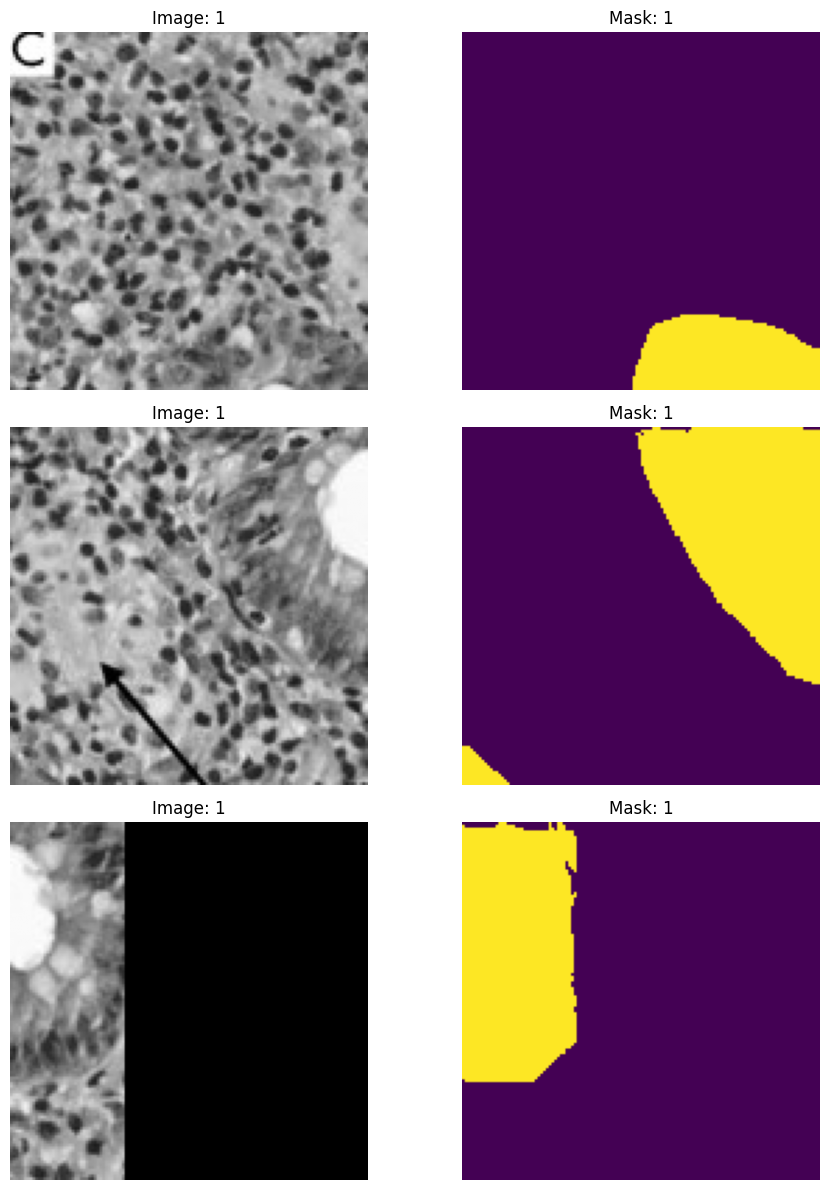

In [ ]:

# Visualize some patches
def visualize_patches(patches: List[PatchData], n_samples=3):
    """Visualize a few sample patches for inspection"""
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 4 * n_samples))
    if n_samples == 1:
        axes = [axes]  # Make sure axes is a list for single sample

    for i, patch_info in enumerate(patches[:n_samples]):
        img_patch = patch_info["img_patch"]
        mask_patch = patch_info["mask_patch"]

        axes[i][0].imshow(img_patch, cmap="gray")
        axes[i][0].set_title(f"Image: {patch_info['cell_id']}")
        axes[i][0].axis("off")

        axes[i][1].imshow(mask_patch, cmap="viridis")
        axes[i][1].set_title(f"Mask: {patch_info['cell_id']}")
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()


# Convert images with masks to patches
patches = convert2patches(images_with_masks)

print(f"Converted {len(patches)} patches from {len(images_with_masks)} images with masks")

# Visualize a few sample patches
if len(patches) > 0:
    visualize_patches(patches[30:], n_samples=3)

## 3. Create Dataset and DataLoader

Create a PyTorch Dataset class to load the patches and a DataLoader for batch training.

Training batches: 5
Validation batches: 2
Batch shape - Images: torch.Size([16, 1, 128, 128]), Masks: torch.Size([16, 1, 128, 128])
Value ranges - Images: [0.00, 1.00], Masks: [0.00, 1.00]


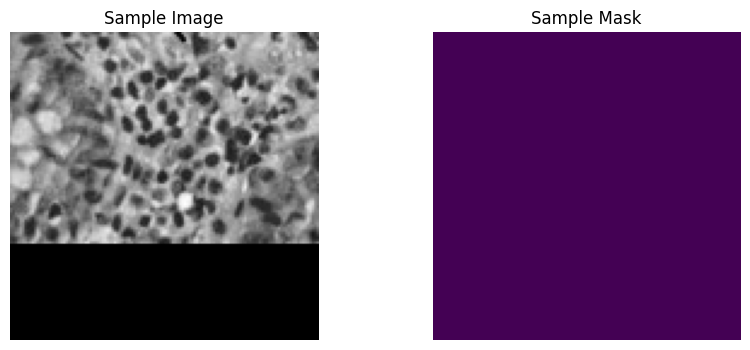

In [ ]:

# Split patches into training and validation sets
train_size = int(0.8 * len(patches))
# Create dataloaders
batch_size = 16
train_dataset = PatchDataset(patches[:train_size])
val_dataset = PatchDataset(patches[train_size:])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Check a batch
if len(train_loader) > 0:
    sample_batch = next(iter(train_loader))
    images, masks = sample_batch
    print(f"Batch shape - Images: {images.shape}, Masks: {masks.shape}")
    print(
        f"Value ranges - Images: [{images.min():.2f}, {images.max():.2f}], Masks: [{masks.min():.2f}, {masks.max():.2f}]"
    )

    # Visualize a sample
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(images[0, 0].numpy(), cmap="gray")
    axes[0].set_title("Sample Image")
    axes[0].axis("off")

    axes[1].imshow(masks[0, 0].numpy(), cmap="viridis")
    axes[1].set_title("Sample Mask")
    axes[1].axis("off")

    plt.show()

## 4. Define Loss Functions and Training Utilities

Implement the dice loss and other training utilities for the U-Net model.

In [6]:
# Generated by Copilot
# Define loss functions
def dice_coef(pred, target, smooth=1.0):
    """Calculate Dice coefficient"""
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()

    return (2.0 * intersection + smooth) / (
        pred_flat.sum() + target_flat.sum() + smooth
    )


def dice_loss(pred, target, smooth=1.0):
    """Dice loss function"""
    return 1 - dice_coef(pred, target, smooth)


def combined_loss(pred, target):
    """Combined BCE and Dice loss"""
    bce = nn.BCEWithLogitsLoss()(pred, target)
    pred_sigmoid = torch.sigmoid(pred)
    dice = dice_loss(pred_sigmoid, target)
    return 0.5 * bce + 0.5 * dice


# Evaluation metrics
def calculate_metrics(pred, target, threshold=0.5):
    """Calculate metrics for evaluation"""
    # Apply sigmoid and threshold
    pred_sigmoid = torch.sigmoid(pred)
    pred_binary = (pred_sigmoid > threshold).float()

    # Move to CPU for numpy operations
    pred_binary = pred_binary.cpu().detach()
    target = target.cpu().detach()

    # Calculate accuracy
    accuracy = (pred_binary == target).float().mean().item()

    # Calculate Dice coefficient
    dice = dice_coef(pred_binary, target).item()

    # Calculate IoU (Intersection over Union)
    intersection = (pred_binary * target).sum().item()
    union = pred_binary.sum().item() + target.sum().item() - intersection
    iou = intersection / union if union > 0 else 0.0

    return {"accuracy": accuracy, "dice": dice, "iou": iou}


# Training and validation functions
def train_epoch(model, dataloader, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0

    for batch_idx, (images, masks) in enumerate(tqdm(dataloader, desc="Training")):
        # Move data to device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = combined_loss(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()

    return running_loss / len(dataloader)


def validate(model, dataloader, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    metrics = {"accuracy": 0.0, "dice": 0.0, "iou": 0.0}

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = combined_loss(outputs, masks)

            # Update statistics
            running_loss += loss.item()

            # Calculate metrics
            batch_metrics = calculate_metrics(outputs, masks)
            for key in metrics:
                metrics[key] += batch_metrics[key]

    # Average metrics
    for key in metrics:
        metrics[key] /= len(dataloader)

    return running_loss / len(dataloader), metrics

## 5. Set Up the U-Net Model

Initialize the U-Net model using the class defined in your AI service modules.

In [7]:
# Generated by Copilot
# Initialize the U-Net model
model = UNet(n_channels=1, n_classes=1, bilinear=True)
model = model.to(device)

# Check if a previously trained model exists
model_file = model_path / "unet_pytorch.pth"
if model_file.exists():
    try:
        model.load_state_dict(torch.load(model_file, map_location=device))
        print(f"Loaded existing model from {model_file}")
    except Exception as e:
        print(f"Error loading model: {e}")


# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model parameters: {count_parameters(model):,}")

# Set up optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, verbose=True
)

# Display model architecture
print(model)

Loaded existing model from /mnt/d/Vault/Coding/02_Projects/AI_Dev/CrohnScope/backend/data/models/unet_pytorch.pth
Model parameters: 17,261,825
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

/mnt/d/Vault/Coding/02_Projects/AI_Dev/CrohnScope/backend/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## 6. Train the Model

Train the U-Net model using the prepared data and track the training progress.

In [ ]:
# Generated by Copilot
# Training parameters
num_epochs = 50
early_stopping_patience = 10

# Training history
history = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": [],
    "val_dice": [],
    "val_iou": [],
}

# Early stopping variables
best_val_loss = float("inf")
no_improve_epoch = 0

# Train the model
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, device)

    # Validate
    val_loss, val_metrics = validate(model, val_loader, device)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(
        f"Val Metrics - Accuracy: {val_metrics['accuracy']:.4f}, Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}"
    )

    # Update history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_metrics["accuracy"])
    history["val_dice"].append(val_metrics["dice"])
    history["val_iou"].append(val_metrics["iou"])

    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(model.state_dict(), str(model_path / "unet_pytorch_best.pth"))
        print(f"Saved best model with validation loss: {val_loss:.4f}")
        no_improve_epoch = 0
    else:
        no_improve_epoch += 1

    # Save the current model state
    torch.save(model.state_dict(), str(model_path / "unet_pytorch.pth"))

    # Early stopping
    if no_improve_epoch >= early_stopping_patience:
        print(
            f"Early stopping at epoch {epoch}. No improvement for {early_stopping_patience} epochs."
        )
        break

    # If dice is very high, we can also stop
    if val_metrics["dice"] > 0.95:
        print(
            f"Stopping at epoch {epoch}. Achieved very high Dice score: {val_metrics['dice']:.4f}"
        )
        break

# Plot training history
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(history["val_accuracy"], label="Accuracy")
plt.plot(history["val_dice"], label="Dice")
plt.title("Accuracy and Dice")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

# Plot IoU
plt.subplot(1, 3, 3)
plt.plot(history["val_iou"], label="IoU")
plt.title("IoU (Intersection over Union)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()

## 7. Evaluate the Model

Evaluate the trained model on the validation set and visualize the results.

In [ ]:
# Generated by Copilot
# Load the best model
best_model_path = model_path / "unet_pytorch_best.pth"
if best_model_path.exists():
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Loaded best model from {best_model_path}")

# Set model to evaluation mode
model.eval()


# Function to visualize predictions
def visualize_predictions(model, dataloader, num_samples=5):
    """Visualize model predictions on samples from the dataloader"""
    model.eval()

    # Get a batch of data
    dataiter = iter(dataloader)
    images, masks = next(dataiter)

    # Make predictions
    with torch.no_grad():
        images_device = images.to(device)
        outputs = model(images_device)
        preds = torch.sigmoid(outputs) > 0.5

    # Move tensors to CPU for plotting
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Plot images, masks, and predictions
    n = min(num_samples, len(images))
    plt.figure(figsize=(15, 5 * n))

    for i in range(n):
        # Original image
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(images[i, 0], cmap="gray")
        plt.title(f"Image {i+1}")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(masks[i, 0], cmap="viridis")
        plt.title(f"Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(preds[i, 0], cmap="viridis")
        plt.title(f"Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Visualize predictions on validation set
if len(val_loader) > 0:
    visualize_predictions(model, val_loader, num_samples=5)